In [30]:
!pip3 install transforms3d
!pip3 install jax
!pip3 install jaxlib
!pip3 install autograd

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import time
# import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# import importlib

import transforms3d as t3d

# import jax.numpy as jnp
# from jax import grad, jacrev
# from jax import random

import autograd
import autograd.numpy as np

import load_data
from rotplot import rotplot
# from utils import *

In [2]:
GRAVITY = -1.0

## Load Dataset

In [38]:
# load data
dataset_index = "11"

start_time = time.time()
if dataset_index in ["1", "2", "8", "9", "10", "11"]:
    cfile = "../data/testset/cam/cam" + dataset_index + ".p"
    camd = load_data.read_data(cfile)
    print("Camera data:", camd.keys(), camd['cam'].shape, camd['ts'].shape)
    cam_arr, cam_ts_unix = np.transpose(camd['cam'], (3, 0, 1, 2)), camd['ts'].T
    cam_ts = cam_ts_unix - cam_ts_unix[0]
else:
    camd = None

ifile = "../data/testset/imu/imuRaw" + dataset_index + ".p"
imud = load_data.read_data(ifile)
imu_arr, imu_ts_unix = np.array(imud['vals'].T, dtype=np.float32), imud['ts'].T
imu_arr[:, [5, 3, 4]] = imu_arr[:, [3, 4, 5]]
imu_ts = imu_ts_unix - imu_ts_unix[0]

if dataset_index not in ["10", "11"]:
    vfile = "../data/trainset/vicon/viconRot" + dataset_index + ".p"
    vicd = load_data.read_data(vfile)
    vic_arr, vic_ts_unix = np.transpose(vicd['rots'], (2, 0, 1)), vicd['ts'].T
    vic_ts = vic_ts_unix - vic_ts_unix[0]
    print("VICON data:", vicd.keys(), vicd['rots'].shape, vicd['ts'].shape)

print('%s took: %s sec.\n' % ("Data import", round(time.time() - start_time, 4)))

print("Raw Data:")
print("IMU data:", imud.keys(), imud['vals'].shape, imud['ts'].shape)

Camera data: dict_keys(['cam', 'ts']) (240, 320, 3, 161) (1, 161)
Data import took: 0.4982 sec.

Raw Data:
IMU data: dict_keys(['vals', 'ts']) (6, 5441) (1, 5441)


## Plot IMU Acclm and Gyroscope data (raw / biased)

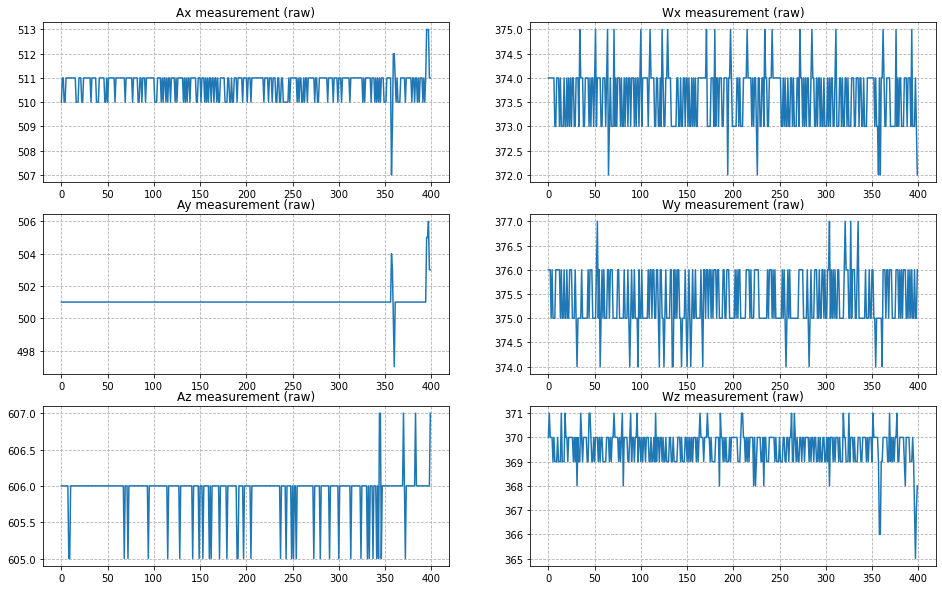

In [42]:
# plot IMU accelerometer data (biased)
num_samp_plot = 400
fig = plt.figure(figsize=(16,10))
plt.subplot(3, 2, 1)
plt.plot(imu_arr[0:num_samp_plot, 0])
plt.grid(linestyle='--')
plt.title("Ax measurement (raw)")

plt.subplot(3, 2, 3)
plt.plot(imu_arr[0:num_samp_plot, 1])
plt.grid(linestyle='--')
plt.title("Ay measurement (raw)")

plt.subplot(3, 2, 5)
plt.plot(imu_arr[0:num_samp_plot, 2])
plt.grid(linestyle='--')
plt.title("Az measurement (raw)")

# plot IMU gyroscope data (biased)
# num_samp_plot = 1000
plt.subplot(3, 2, 2)
plt.plot(imu_arr[0:num_samp_plot, 3])
plt.grid(linestyle='--')
plt.title("Wx measurement (raw)")

plt.subplot(3, 2, 4)
plt.plot(imu_arr[0:num_samp_plot, 4])
plt.grid(linestyle='--')
plt.title("Wy measurement (raw)")

plt.subplot(3, 2, 6)
plt.plot(imu_arr[0:num_samp_plot, 5])
plt.grid(linestyle='--')
plt.title("Wz measurement (raw)")

plt.show()

## IMU calibration - Compute bias, sensitivity & scale factor

In [6]:
Vref = 3300.0
sens_gyro = 3.33 / (np.pi/180)
sens_acclm = 300 / np.abs(GRAVITY)
print("Sensitivity: Acclm =", sens_acclm, "mV/m/sec2,  Gyro =", sens_gyro, "mV/rad/sec")

scale_gyro = Vref / (1023 * sens_gyro)
scale_acclm = Vref / (1023 * sens_acclm)
print("Scale: Acclm = ", scale_acclm, "m/sec2,  Gyro =", scale_gyro, "rad-sec")

# estimate accelerometer bias
num_init_samp_bias = 500
imu_acclm_bias = np.mean(imu_arr[0:num_init_samp_bias, 0:3], axis=0)
imu_acclm_bias_gravity = np.abs(GRAVITY) / scale_acclm
imu_acclm_bias[2] = imu_acclm_bias[2] - imu_acclm_bias_gravity
print("Accelerometer bias:", imu_acclm_bias)

# estimate gyrometer bias
num_init_samp_bias = 500
imu_gyro_bias = np.mean(imu_arr[0:num_init_samp_bias, 3:6], axis=0)
print("Gyroscope bias:", imu_gyro_bias)

Sensitivity: Acclm = 300.0 mV/m/sec2,  Gyro = 190.79494577856414 mV/rad/sec
Scale: Acclm =  0.010752688172043012 m/sec2,  Gyro = 0.01690719027409018 rad-sec
Accelerometer bias: [510.808 500.994 512.164]
Gyroscope bias: [373.568 375.356 369.68 ]


## Estimate calibrated Acclm and gyroscope data

In [7]:
imu_arr_cal = np.copy(imu_arr)
imu_arr_cal[:, 0:3] = (imu_arr_cal[:, 0:3] - imu_acclm_bias) * scale_acclm
imu_arr_cal[:, 0:2] = imu_arr_cal[:, 0:2] * -1.0
imu_arr_cal[:, 3:6] = (imu_arr_cal[:, 3:6] - imu_gyro_bias) * scale_gyro

print("Acclerometer data (calibrated):\n", imu_arr_cal[:, 0:3])
print("Gyroscope data (calibrated):\n", imu_arr_cal[:, 3:6])

Acclerometer data (calibrated):
 [[-2.0643666e-03 -6.4644759e-05  9.9823654e-01]
 [-2.0643666e-03 -6.4644759e-05  9.9823654e-01]
 [-2.0643666e-03 -6.4644759e-05  1.0089892e+00]
 ...
 [-2.0643666e-03  1.0688043e-02  9.9823654e-01]
 [-2.0643666e-03  1.0688043e-02  9.9823654e-01]
 [-2.0643666e-03  1.0688043e-02  1.0089892e+00]]
Gyroscope data (calibrated):
 [[ 0.00730402  0.01088844  0.00541042]
 [-0.00960317  0.01088844 -0.01149677]
 [ 0.00730402 -0.00601875  0.00541042]
 ...
 [-0.00960317 -0.00601875 -0.01149677]
 [ 0.00730402  0.01088844 -0.01149677]
 [-0.00960317 -0.00601875 -0.01149677]]


## Plot IMU Acclm and Gyroscope data (full calibrated)

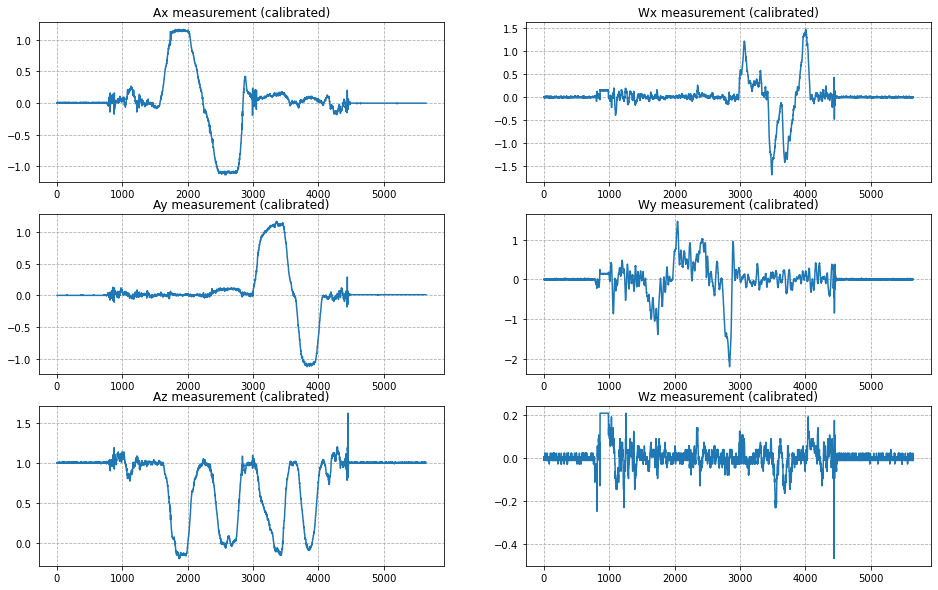

In [8]:
# plot IMU accelerometer data (calibrated)
num_samp_plot = imu_arr.shape[0]
fig = plt.figure(figsize=(16,10))
plt.subplot(3, 2, 1)
plt.plot(imu_arr_cal[0:num_samp_plot, 0])
plt.grid(linestyle='--')
plt.title("Ax measurement (calibrated)")

plt.subplot(3, 2, 3)
plt.plot(imu_arr_cal[0:num_samp_plot, 1])
plt.grid(linestyle='--')
plt.title("Ay measurement (calibrated)")

plt.subplot(3, 2, 5)
plt.plot(imu_arr_cal[0:num_samp_plot, 2])
plt.grid(linestyle='--')
plt.title("Az measurement (calibrated)")

# plot IMU gyroscope data (calibrated)
num_samp_plot = imu_arr.shape[0]
plt.subplot(3, 2, 2)
plt.plot(imu_arr_cal[0:num_samp_plot, 3])
plt.grid(linestyle='--')
plt.title("Wx measurement (calibrated)")

plt.subplot(3, 2, 4)
plt.plot(imu_arr_cal[0:num_samp_plot, 4])
plt.grid(linestyle='--')
plt.title("Wy measurement (calibrated)")

plt.subplot(3, 2, 6)
plt.plot(imu_arr_cal[0:num_samp_plot, 5])
plt.grid(linestyle='--')
plt.title("Wz measurement (calibrated)")

plt.show()

In [88]:
a = np.random.randint(0, 9, (5,3))
print(a)

q0 = np.array([1,0,0], dtype=np.float32)
b = np.vstack([q0, a])
print(b)

c = np.linalg.norm(a, axis=1)
d = c + 1e-2
print(c)
print(d)

[[8 2 4]
 [2 2 0]
 [5 3 8]
 [5 2 6]
 [2 2 5]]
[[1. 0. 0.]
 [8. 2. 4.]
 [2. 2. 0.]
 [5. 3. 8.]
 [5. 2. 6.]
 [2. 2. 5.]]
[9.16515139 2.82842712 9.89949494 8.06225775 5.74456265]
[9.17515139 2.83842712 9.90949494 8.07225775 5.75456265]


In [108]:
def compute_exp_quat_mat(q):
    assert(q.shape[1] == 4)
    
    qv_mag = np.linalg.norm(q[:, 1:], axis=1)
    idx = np.where(qv_mag > 0)[0]
    
    exp_q = np.zeros_like(q)
    exp_q[:, 0] = np.exp(q[:, 0]) * np.cos(qv_mag)
    exp_q[idx, 1:] = np.expand_dims(np.exp(q[idx, 0]) * np.sin(qv_mag[idx]), axis=1) * (q[idx, 1:] / np.expand_dims(qv_mag[idx], axis=1))
    
    return exp_q


def compute_quat_inv_mat(q):
    assert(q.shape[1] == 4)

    q_inv = np.array([q[:,0], -q[:,1], -q[:,2], -q[:,3]]).T
    q_inv = q_inv / np.expand_dims(np.square(np.linalg.norm(q, axis=1)), axis=1)
    
    return q_inv


def compute_quat_prod_mat(q, p):
    assert(q.shape[1] == p.shape[1] == 4)
    
    first_col = q[:,0] * p[:,0] - np.sum(q[:,1:] * p[:,1:], axis=1)
    sec_to_four_col = np.expand_dims(q[:,0], axis=1) * p[:,1:] + np.expand_dims(p[:,0], axis=1) * q[:,1:] + np.cross(q[:,1:], p[:,1:])
    
    quat_prod = np.array([first_col, sec_to_four_col[:,0], sec_to_four_col[:,1], sec_to_four_col[:,2]]).T
    return quat_prod


def compute_log_quat_mat(q):
    assert(q.shape[1] == 4)
    
    qv_mag = np.linalg.norm(q[:, 1:], axis=1) + 1e-10
    q_mag = np.linalg.norm(q, axis=1) + 1e-10
#     idx = np.where(qv_mag == 0)[0]

    first_col = np.log(q_mag)
    sec_to_four_col = np.expand_dims(np.arccos(q[:, 0] / q_mag), axis=1) * q[:, 1:] / np.expand_dims(qv_mag, axis=1)
    
    log_q = np.array([first_col, sec_to_four_col[:,0], sec_to_four_col[:,1], sec_to_four_col[:,2]])
    return log_q


def compute_f_mat(q, tau, omega):
    assert(q.shape[0] == omega.shape[0] == tau.shape[0])
    
    quat_omega = np.zeros_like(q)
    quat_omega[:, 1:] = tau * omega / 2
    exp_quat_omega = compute_exp_quat_mat(quat_omega)
    f_out = compute_quat_prod_mat(q, exp_quat_omega)
    
    return f_out


def compute_h_mat(q, GRAVITY):
    tmp = np.zeros_like(q)
    tmp[:, 3] = -GRAVITY

    return compute_quat_prod_mat(compute_quat_prod_mat(compute_quat_inv_mat(q), tmp), q)

In [102]:
def compute_exp_quat(q):
    qv_mag = np.linalg.norm(q[1:])
    
    if qv_mag == 0:
        exp_q = np.array([np.exp(q[0]), 0, 0, 0], dtype=np.float32)
    else:
        tmp = (q[1:] / qv_mag) * np.sin(qv_mag)
        exp_q = np.exp(q[0]) * np.array([np.cos(qv_mag), tmp[0], tmp[1], tmp[2]])
    
    return exp_q

def compute_log_quat(q):
    qv_mag = np.linalg.norm(q[1:])
    
    if qv_mag == 0:
        log_q = np.array([np.log(np.abs(q[0])), 0, 0, 0], dtype=np.float32)
    else:
        q_mag = np.linalg.norm(q)
        tmp = (q[1:] / qv_mag) * np.arccos(q[0] / q_mag)
        log_q = np.array([np.log(q_mag), tmp[0], tmp[1], tmp[2]])
    
    return log_q

def compute_quat_inv(q):
    q_inv = np.array([q[0], -q[1], -q[2], -q[3]])
    q_inv = q_inv / np.linalg.norm(q)**2
    
    return q_inv

def compute_quat_prod(q, p):
    assert(q.shape[0] == p.shape[0] == 4)
    tmp = np.array([q[0] * p[1:] + p[0] * q[1:] + np.cross(q[1:], p[1:])])
    quat_prod = np.array([q[0] * p[0] - np.dot(q[1:], p[1:]), tmp[0,0], tmp[0,1], tmp[0,2]])
    
    return quat_prod

def compute_f(q, tau, omega):
    quat_omega = np.insert(tau * omega / 2, 0, 0)
    exp_quat_omega = compute_exp_quat(quat_omega)
    f_out = compute_quat_prod(q, exp_quat_omega)
    
    return f_out

def compute_h(q, GRAVITY):
    tmp = np.array([0, 0, 0, -GRAVITY], dtype=np.float32)
    return compute_quat_prod(compute_quat_prod(compute_quat_inv(q), tmp), q)

## Estimate True vs Estimated Roll, Pitch, Yaw

In [103]:
start_time = time.time()

# estimate true euler rotation angles from VICON data
num_vic_ts = vic_ts.shape[0]
vic_rpy_arr = np.zeros((num_vic_ts, 3), dtype=np.float32)
vic_quat_arr = np.zeros((num_vic_ts, 4), dtype=np.float32)
# accln_pred_vic_quat = np.zeros((num_vic_ts, 3), dtype=np.float32)

for t in range(num_vic_ts):
    rot_mat = vic_arr[t]
    vic_rpy_arr[t, :] = np.array(t3d.euler.mat2euler(rot_mat)) * 180 / np.pi
    vic_quat_arr[t, :] = np.array(t3d.quaternions.mat2quat(rot_mat))
    
    # compute acceleration using the VICON quaternion data and observation model
#     accln_pred_vic_quat[t, :] = compute_h(vic_quat_arr[t, :])[1:]

accln_pred_vic_quat = compute_h_mat(vic_quat_arr, GRAVITY)[:, 1:]
# print("Diff Saqib:", np.mean(np.abs(accln_pred_vic_quat - accln_pred_vic_quat_mat)))


# estimate predicted euler angles from IMU data using quaternion kinematics motion model
num_imu_ts = imu_ts.shape[0]

quat_pred = np.zeros((num_imu_ts, 4), dtype=np.float32)
quat_pred[0] = np.array([1, 0, 0, 0], dtype=np.float32)   # define q0

imu_pred_rpy_arr = np.zeros((num_imu_ts, 3), dtype=np.float32)
imu_pred_rpy_arr[0] = np.array(t3d.euler.quat2euler(quat_pred[0], axes='sxyz')) * 180 / np.pi

# accln_pred_imu_quat = np.zeros((num_imu_ts, 3), dtype=np.float32)
# accln_pred_imu_quat[0] = compute_h(quat_pred[0])[1:]

for t in range(num_imu_ts - 1):
    tau_t = imu_ts[t+1] - imu_ts[t]
    omega_t = imu_arr_cal[t, 3:6]
    quat_pred[t+1] = compute_f(quat_pred[t], tau_t, omega_t)
    
    imu_pred_rpy_arr[t+1, :] = np.array(t3d.euler.quat2euler(quat_pred[t+1], axes='sxyz')) * 180 / np.pi
    
    # compute acceleration using the IMU quaternion data and observation model
#     accln_pred_imu_quat[t+1] = compute_h(quat_pred[t+1])[1:]

accln_pred_imu_quat = compute_h_mat(quat_pred, GRAVITY)[:, 1:]
# print("Diff Saqib Bhai:", np.mean(np.abs(accln_pred_imu_quat - accln_pred_imu_quat_mat)))

print("Time taken:", round(time.time() - start_time, 4))

Time taken: 1.348


## Plot True vs Estimated Roll, Pitch, Yaw

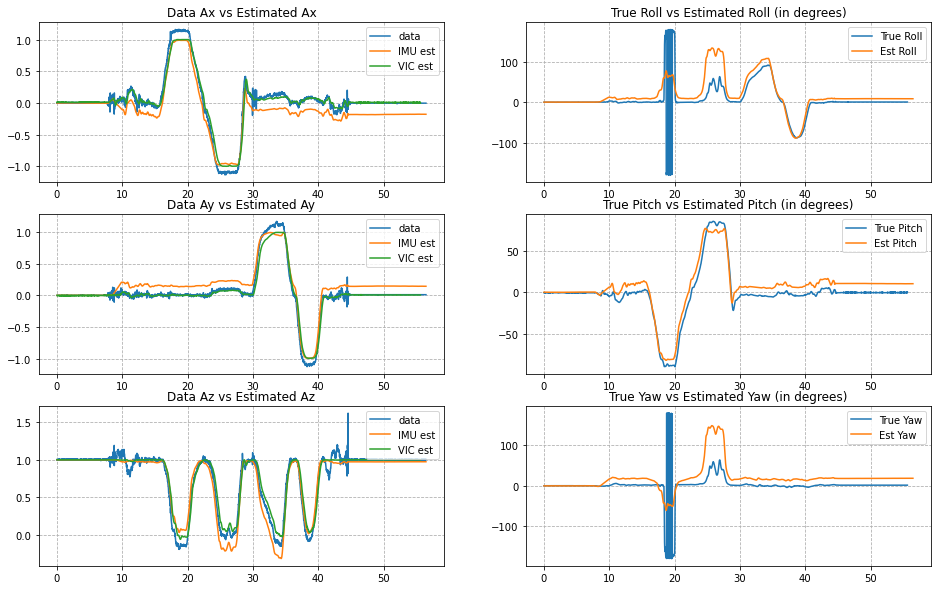

In [104]:
fig = plt.figure(figsize=(16,10))

plt.subplot(3, 2, 1)
plt.plot(imu_ts[0:num_imu_ts], imu_arr_cal[:,0], label="data")
plt.plot(imu_ts[0:num_imu_ts], accln_pred_imu_quat[:,0], label="IMU est")
plt.plot(vic_ts[0:num_vic_ts], accln_pred_vic_quat[:,0], label="VIC est")
plt.grid(linestyle='--')
plt.title("Data Ax vs Estimated Ax")
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(imu_ts[0:num_imu_ts], imu_arr_cal[:,1], label="data")
plt.plot(imu_ts[0:num_imu_ts], accln_pred_imu_quat[:,1], label="IMU est")
plt.plot(vic_ts[0:num_vic_ts], accln_pred_vic_quat[:,1], label="VIC est")
plt.grid(linestyle='--')
plt.title("Data Ay vs Estimated Ay")
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(imu_ts[0:num_imu_ts], imu_arr_cal[:,2], label="data")
plt.plot(imu_ts[0:num_imu_ts], accln_pred_imu_quat[:,2], label="IMU est")
plt.plot(vic_ts[0:num_vic_ts], accln_pred_vic_quat[:,2], label="VIC est")
plt.grid(linestyle='--')
plt.title("Data Az vs Estimated Az")
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(vic_ts[0:num_vic_ts], vic_rpy_arr[:,0], label="True Roll")
plt.plot(imu_ts[0:num_imu_ts], imu_pred_rpy_arr[:,0], label="Est Roll")
plt.grid(linestyle='--')
plt.title("True Roll vs Estimated Roll (in degrees)")
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(vic_ts[0:num_vic_ts], vic_rpy_arr[:,1], label="True Pitch")
plt.plot(imu_ts[0:num_imu_ts], imu_pred_rpy_arr[:,1], label="Est Pitch")
plt.grid(linestyle='--')
plt.title("True Pitch vs Estimated Pitch (in degrees)")
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(vic_ts[0:num_vic_ts], vic_rpy_arr[:,2], label="True Yaw")
plt.plot(imu_ts[0:num_imu_ts], imu_pred_rpy_arr[:,2], label="Est Yaw")
plt.grid(linestyle='--')
plt.title("True Yaw vs Estimated Yaw (in degrees)")
plt.legend()

plt.show()

In [119]:
# REye = np.eye(3)
# myAxis = rotplot(REye)
# RTurn = np.array([[np.cos(np.pi/2),0,np.sin(np.pi/2)],[0,1,0],[-np.sin(np.pi/2),0,np.cos(np.pi/2)]])
# rotplot(RTurn,myAxis)
# plt.show()

In [118]:
def compute_cost_func_mat(quat_opt_var):
    eps = 1e-10
    noise = np.random.rand(quat_opt_var.shape[0], quat_opt_var.shape[1]) * eps

    q0 = np.array([1, 0, 0, 0], dtype=np.float32)
    cost = 0
    T = quat_opt_var.shape[0]
    
    q_inv_mat = compute_quat_inv_mat(quat_opt_var)
    h_mat = compute_h_mat(quat_opt_var, GRAVITY)[:, 1:]

    tmp = np.vstack([q0, quat_opt_var[0:-1]])
    
    tau_mat = imu_ts[1:] - imu_ts[0:-1]
    omega_mat = imu_arr_cal[:-1, 3:6]

    f_out = compute_f_mat(tmp, tau_mat, omega_mat)
    
    tmp1 = compute_quat_prod_mat(q_inv_mat, f_out) + noise
    tmp2 = 2 * compute_log_quat_mat(tmp1)
    
    tmp3 = np.sum(np.square(np.linalg.norm(tmp2, axis=1)))
    tmp4 = np.sum(np.square(np.linalg.norm(imu_arr_cal[1:, 0:3] - h_mat, axis=1)))
    
    cost = 0.5 * (tmp3 + tmp4)

    return cost

In [110]:
# def compute_cost_func(quat_opt_var):
#     eps = 1e-5
#     noise = np.random.rand(4) * eps

#     q0 = np.array([1, 0, 0, 0], dtype=np.float32)
#     cost = 0
#     T = quat_opt_var.shape[0]
    
#     for t in range(0, T):
#         tau_t = imu_ts[t+1] - imu_ts[t]
#         omega_t = imu_arr_cal[t, 3:6]
#         f_out = compute_f(q0, tau_t, omega_t) if t == 0 else compute_f(quat_opt_var[t-1], tau_t, omega_t)
        
#         tmp = compute_quat_prod(compute_quat_inv(quat_opt_var[t]), f_out)
#         cost = cost + np.linalg.norm(2 * compute_log_quat(tmp + noise) + noise)**2
        
#         h_out = compute_h(quat_opt_var[t], GRAVITY)[1:]
#         accln_t = imu_arr_cal[t+1, 0:3]
#         cost = cost + np.linalg.norm(accln_t - h_out + noise[0:3])**2
    
#     cost = cost * 0.5
#     return cost

In [44]:
# import numpy
a = np.random.rand(10,4).astype(np.float32)
b = np.random.rand(10,4).astype(np.float32)

res = np.zeros((10,4))
# for i in range(10):
#     res[i] = compute_exp_quat(b[i])
# print(res - compute_exp_quat_mat(b))

# for i in range(10):
#     res[i] = compute_quat_inv(b[i])
# print(res - compute_quat_inv_mat(b))

# for i in range(10):
#     res[i] = compute_quat_prod(a[i], b[i])
# print(res - compute_quat_prod_mat(a, b))

# for i in range(10):
#     res[i] = compute_log_quat(b[i])
# print(res - compute_log_quat_mat(b))

# for i in range(10):
#     res[i] = compute_h(b[i])


# start_time = time.time()
# res1 = compute_cost_func(b)
# print("Time taken:", time.time() - start_time)
# start_time = time.time()
# res2 = compute_cost_func_mat(b)
# print("Time taken:", time.time() - start_time)
# print("Finally saqib:", res1, res2)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.98023224e-08  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.96046448e-08  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


## Perform PGD steps

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

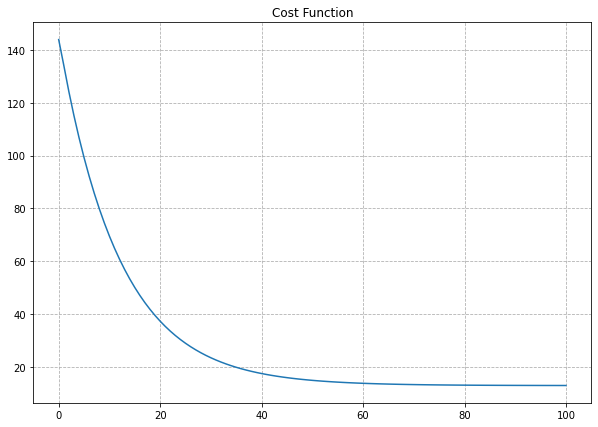

In [119]:
q0 = np.array([1, 0, 0, 0], dtype=np.float32)

# estimate predicted euler angles from IMU data using quaternion kinematics motion model
num_imu_ts = imu_ts.shape[0]    # 5645
T = num_imu_ts - 1              # 5644

# initialize quaternion optimization variables q1:T
quat_opt_var = np.zeros((T, 4), dtype=np.float32)
for t in range(0, T):
    tau_t = imu_ts[t+1] - imu_ts[t]
    omega_t = imu_arr_cal[t, 3:6]
    quat_opt_var[t] = compute_f(q0, tau_t, omega_t) if t == 0 else compute_f(quat_opt_var[t-1], tau_t, omega_t)

cost_lst = [compute_cost_func_mat(quat_opt_var)]

# grad_cost_fn = autograd.grad(compute_cost_func)
grad_cost_fn = autograd.jacobian(compute_cost_func_mat)

num_itr = 100
learning_rate = 1e-2
start_time = time.time()

for itr in range(num_itr):
    print("Iteration:", itr)
    quat_opt_var = quat_opt_var - learning_rate * grad_cost_fn(quat_opt_var)
    quat_opt_var = quat_opt_var / np.reshape(np.linalg.norm(quat_opt_var, axis=1), (T, 1))
    
    cost_lst.append(compute_cost_func_mat(quat_opt_var))

print("Time taken:", round(time.time() - start_time, 5))

fig = plt.figure(figsize=(10, 7))
plt.plot(cost_lst)
plt.grid(linestyle='--')
plt.title("Cost Function")
plt.show()

In [112]:
cost_lst

[143.86512978691002,
 133.33279972456344,
 123.64469807207306,
 114.73360422009416,
 106.53763817600029,
 98.9998305394218,
 92.06775147095705,
 85.6930941050557,
 79.83135783972475,
 74.44156533559477,
 69.48594090834801,
 64.92973929682552,
 60.74089434642255,
 56.88994519590221,
 53.3497347635485,
 50.09527378255875,
 47.10355979597879,
 44.353434524289966,
 41.82541544600423,
 39.50159965413334,
 37.36550328840817,
 35.401962213920704,
 33.59705154770085,
 31.937944516850134,
 30.41286657136692,
 29.01096954910598,
 27.722302963560985,
 26.53770350569307,
 25.448754885254846,
 24.447722963657142,
 23.527493004710404,
 22.6815295668385,
 21.90382490361549,
 21.188855416274947,
 20.5315527948619,
 19.927246920106423,
 19.371658310821907,
 18.860842780935247,
 18.391181951488335,
 17.959346983951146,
 17.562287234389352,
 17.197188257938958,
 16.861469948200057,
 16.552761693280623,
 16.268875781105827,
 16.007815920535432,
 15.767738287881116,
 15.54694561572108,
 15.343887414223582,

## Estimate the roll, pitch, yaw using optimized trajectory

In [113]:
opt_rpy_arr = np.zeros((num_imu_ts, 3), dtype=np.float32)
opt_rpy_arr[0] = np.array(t3d.euler.quat2euler(q0, axes='sxyz')) * 180 / np.pi

for t in range(num_imu_ts-1):
    opt_rpy_arr[t+1] = np.array(t3d.euler.quat2euler(quat_opt_var[t], axes='sxyz')) * 180 / np.pi

## Plot estimated optimized q1:T vs VICON data q1:T

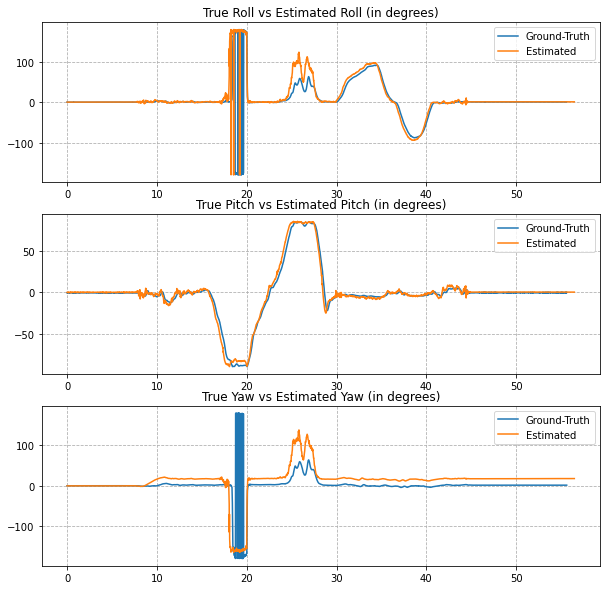

In [114]:
fig = plt.figure(figsize=(10,10))

plt.subplot(3, 1, 1)
plt.plot(vic_ts[0:num_vic_ts], vic_rpy_arr[:,0], label="Ground-Truth")
plt.plot(imu_ts[0:num_imu_ts], opt_rpy_arr[:,0], label="Estimated")
plt.grid(linestyle='--')
plt.title("True Roll vs Estimated Roll (in degrees)")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(vic_ts[0:num_vic_ts], vic_rpy_arr[:,1], label="Ground-Truth")
plt.plot(imu_ts[0:num_imu_ts], opt_rpy_arr[:,1], label="Estimated")
plt.grid(linestyle='--')
plt.title("True Pitch vs Estimated Pitch (in degrees)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(vic_ts[0:num_vic_ts], vic_rpy_arr[:,2], label="Ground-Truth")
plt.plot(imu_ts[0:num_imu_ts], opt_rpy_arr[:,2], label="Estimated")
plt.grid(linestyle='--')
plt.title("True Yaw vs Estimated Yaw (in degrees)")
plt.legend()

plt.show()

# Orientation Tracking

In [14]:
def conv_sph2cart(theta_long, theta_lat, radius=1.0):
    assert(theta_long.shape == theta_lat.shape)
    height, width = theta_lat.shape

    cart_coords = np.zeros((height, width, 3))
    cart_coords[:,:,0] = radius * np.cos(theta_lat) * np.cos(theta_long)
    cart_coords[:,:,1] = radius * np.cos(theta_lat) * np.sin(theta_long)
    cart_coords[:,:,2] = -1 * radius * np.sin(theta_lat)

    return cart_coords

In [15]:
def conv_cart2sph(cart_coords, radius=1):
    X, Y, Z = cart_coords[:,:,0], cart_coords[:,:,1], cart_coords[:,:,2]
    
    theta_lat = np.arcsin(-Z / radius)
    theta_long = np.arctan2(Y, X)
    
    return theta_long, theta_lat

In [122]:
Y = -5
X = -50

res = np.arctan2(Y, X) * 180 / np.pi
print(res)

-174.28940686250036


In [55]:
# img_height = 8
# img_width = 12
# center_u = 4
# center_v = 6

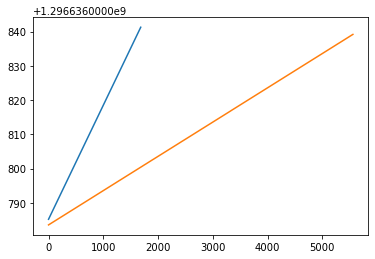

In [50]:
fig = plt.figure()
plt.plot(cam_ts_unix)
plt.plot(vic_ts_unix)
plt.show()

In [54]:
# a = np.random.randint(-9, 9, (20,1))
a = np.arange(10, -10, -1)
print(a)

b = a[a > 0]
b_idx = np.where(a > 0)[0][-1]
print(b)
print(b_idx)

# x, y = np.partition(a, 2)[0:2]
# print(x, y)

[10  9  8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8 -9]
[10  9  8  7  6  5  4  3  2  1]
9


In [81]:
a = np.random.rand(4,4) * 1000
print(a)

a = np.round(a).astype(np.int32)
# a = a.astype(np.int32)
print(a)

[[840.69002914 117.50701884 964.0031094  804.51619138]
 [640.904789   212.98579707 897.69506832 334.85461138]
 [ 85.93194098 904.61538936  82.8276604  645.69175656]
 [973.1552641  339.801384   208.60504501 486.90152757]]
[[841 118 964 805]
 [641 213 898 335]
 [ 86 905  83 646]
 [973 340 209 487]]


In [16]:
def find_camvic_closest_ts(vic_ts_unix, ts):
    tmp = ts - vic_ts_unix
    idx = np.where(tmp > 0)[0][-1]
    return idx

In [28]:
num_cam_ts = cam_ts.shape[0]
num_imgs, img_height, img_width, _ = cam_arr.shape
assert(num_imgs == num_cam_ts)
center_u, center_v = img_height//2, img_width//2
print("Number of Images: {}, Image (H,W): ({},{})".format(num_imgs, img_height, img_width))

# specify the horizontal and vertical FOV in degrees
hor_fov = 60
ver_fov = 45

# specify the panorama output image size
pan_img_height, pan_img_width = 720, 1080
pan_img = np.zeros((pan_img_height+1, pan_img_width+1, 3), dtype=np.uint8)

V, U = np.meshgrid(np.arange(0,img_width), np.arange(0,img_height))

# compute spherical coordinates # (in degrees) assuming linear scale
theta_long_deg = -(V - center_v) * hor_fov / img_width
theta_lat_deg = (U - center_u) * ver_fov / img_height

# convert degrees to radians
theta_long = theta_long_deg * np.pi / 180.0
theta_lat = theta_lat_deg * np.pi / 180.0

# print(theta_long_deg)
# print(theta_lat_deg)

# convert spherical to cartesian coordinates assuming radius/depth=1
cart_coords = conv_sph2cart(theta_long, theta_lat, radius=1)    # (240, 320, 3)

for t in range(num_cam_ts):
    # find the closest-in-the-past timestamp of orientation to each camera image
    vic_closest_idx = find_camvic_closest_ts(vic_ts_unix, cam_ts_unix[t])
    rot_mat_gt = vic_arr[vic_closest_idx]
    
    # rotate cartesian coordinates to world frame using VICON ground-truth R
    cart_coords_rot = np.matmul(cart_coords, rot_mat_gt.T)    # (240, 320, 3)
    
    # convert cartesian back to spherical coordinates
    theta_long_rot, theta_lat_rot = conv_cart2sph(cart_coords_rot)  # (240, 320), (240, 320)

    pan_pix_coords_u = ((theta_lat_rot + np.pi/2) / np.pi) * pan_img_height   # (240, 320)
    pan_pix_coords_v = ((np.pi - theta_long_rot) / (2*np.pi)) * pan_img_width   # (240, 320)
    
    pan_pix_coords_u = np.round(pan_pix_coords_u).astype(np.int32)
    pan_pix_coords_v = np.round(pan_pix_coords_v).astype(np.int32)
    
#     print(pan_pix_coords_u.shape, pan_pix_coords_v.shape)

    pan_img[pan_pix_coords_u, pan_pix_coords_v] = np.copy(cam_arr[t])

Number of Images: 1685, Image (H,W): (240,320)


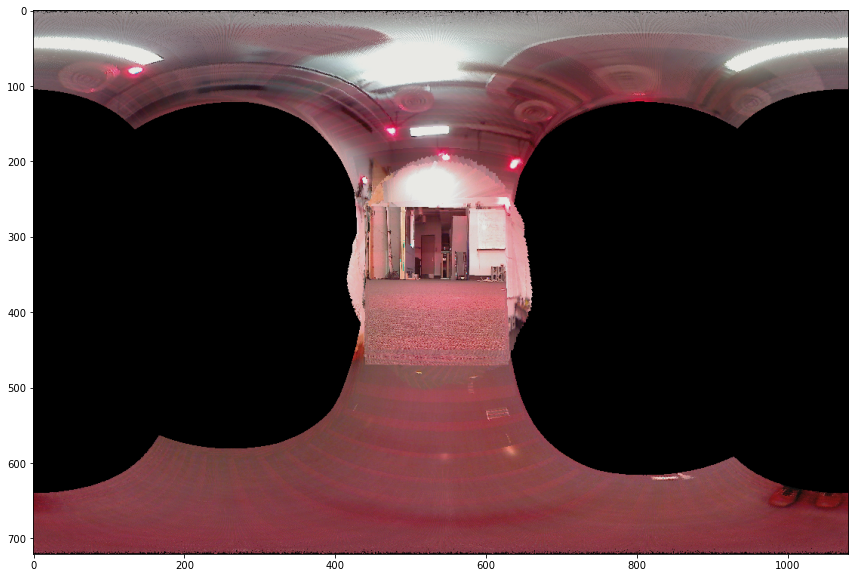

In [29]:
fig = plt.figure(figsize=(15,10))
plt.imshow(pan_img)

(240, 320, 3) (721, 1081, 3)
uint8 uint8


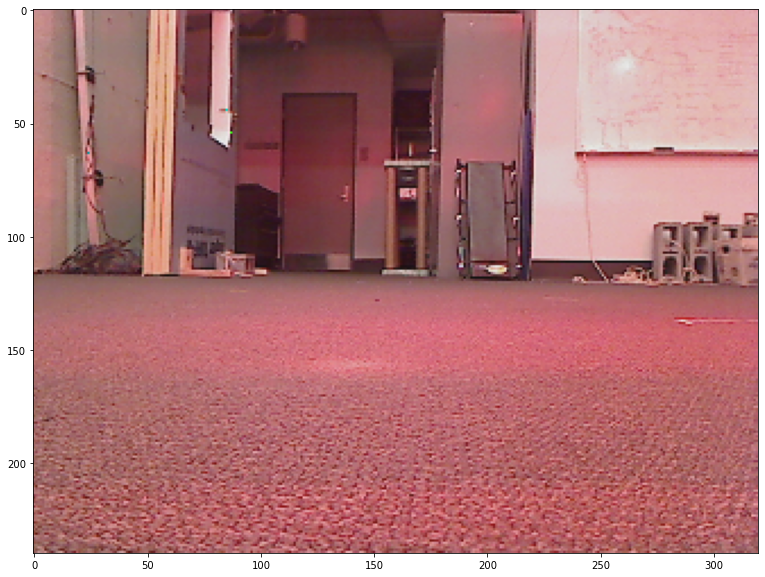

In [19]:
print(cam_arr[0].shape, pan_img.shape)
print(cam_arr[0].dtype, pan_img.dtype)
fig = plt.figure(figsize=(15,10))
plt.imshow(cam_arr[0])